# 三国志を天動説で解読し、邪馬台国ミステリーの謎を解く - 過去から未来に繋がる、点を線で繋ぐ歴史旅 - 


In [215]:
import pyproj; import folium

def next_latlon(latlon,azimuth,distance_m): # [緯度(°),経度(°)],方位角(°),距離(m)
    lon,lat,_=pyproj.Geod(ellps='GRS80').fwd(latlon[1],latlon[0],azimuth,distance_m)
    return [lat,lon] # 方位角(北から時計回りの°)に距離(m)に位置する緯度経度

def add_location(route,title,azimath,distance_ri): # ルートに場所追加
    loc={"title":title,"latlon":next_latlon(route[-1]["latlon"],
        azimath,ri_meter*distance_ri)}; route.append(loc)
    return loc # ルートに場所を追加した上で、追加した場所を返す

def draw_map_and_locations(routes,locations=None):
    m=folium.Map(location=routes[0][0]["latlon"],zoom_start=4,
        width=600,control_scale=True); m.get_root().height=600
    # 下記は商業用途利用時のライセンス手続きに時間がかかるので、採用しない
    #folium.TileLayer(attr='Esri World Imagery',name='Esri World Imagery',
    #tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    #).add_to(m)
    folium.TileLayer(attr='国土地理院+GRUS画像（© Axelspace）',name='全国最新写真(シームレス)',
    tiles='https://cyberjapandata.gsi.go.jp/xyz/seamlessphoto/{z}/{x}/{y}.jpg',
    ).add_to(m)
    folium.TileLayer(attr='国土地理院',name='陰影起伏図',opacity=0.6,
    tiles='https://cyberjapandata.gsi.go.jp/xyz/hillshademap/{z}/{x}/{y}.png').add_to(m)
    folium.LayerControl().add_to(m) # レイヤーコントロールを追加
    for route in routes:
        for i,loc in enumerate(route): # 描く円の半径はmで指定する
            m.add_child(folium.Circle(location=loc["latlon"],color="white",fill=True,
                fill_color="white",fill_opacity=0.1,radius=3*1000,tooltip=loc["title"]))
            if i!=0: # 場所と場所の間を線で繋ぐ（経路が見えるようにする）
                folium.PolyLine(color="#FF7777", weight=5,
                locations=[route[i-1]["latlon"],loc["latlon"]]).add_to(m)
    if locations: # 経路とは別の場所情報が与えられていれば、それも表示する
        for loc in locations: 
            for lat,lon,alt in loc["latlons"]: # 標高データも3番目に入ってる
                folium.Marker(location=[lat,lon],tooltip=loc["fields"],popup=loc["fields"],
                icon=folium.Icon(color="red",icon="info-sign")).add_to(m)
    return m

ri_meter=420;route=[{"title":"帯方郡","latlon":[37.91,126.16]}]
add_location(route,"",180,4000);add_location(route,"釜山（狗邪韓国）",90,3000)
draw_map_and_locations([route])

In [235]:
import geocoder; import math; import numpy as np

def calc_latitude(stick, shadow):
    return math.degrees(math.atan(shadow/stick)) + declination

earth_radius_km =6371;declination=23.44 # 地球半径（km）と夏至に太陽直下の北緯(北回帰線)
km_per_degree=2*np.pi*earth_radius_km/360  # 1°あたりのkm（約111km）
stick=80;shadow=16 # 棒（髀）と影の長さ（単位は寸⇒比率問題なので無次元化する）
center_latitude=calc_latitude(stick,shadow)
loc=geocoder.osm("Luoyang,China",timeout=5.0,headers={"User-Agent":"hirax"}).latlng
print(f"棒の比率が {stick}:{shadow} となる北緯≒ {center_latitude:.2f}°")
print(f"洛陽からの距離は{(center_latitude-loc[0])*km_per_degree:.1f} km")

棒の比率が 80:16 となる北緯≒ 34.75°
洛陽からの距離は14.5 km


In [236]:
print(f"北へ千里は{(center_latitude-calc_latitude(stick,17))*km_per_degree:.1f} km")
print(f"南へ千里は{(center_latitude-calc_latitude(stick,15))*km_per_degree:.1f} km")

北へ千里は-76.4 km
南へ千里は76.8 km


In [230]:
add_location(route,"",165,1300);add_location(route,"対馬国",50,1300/5*2)
add_location(route,"",165,1100);add_location(route,"一大国",50,1100/5*1.5)
add_location(route,"",165,600);add_location(route,"末廬国",50,600/5*1.)
draw_map_and_locations([route])

In [ ]:
import requests;import json;import pandas as pd;import time
import matplotlib.pyplot as plt

data_list = [] # データ(風向きは風上方向（北=0°時計回り）、風速はm/s)
for m in range(13)[1:]: # 1〜12月まで各月の風速情報を取得する
    for d in range(29)[1:]: # 1〜28日まで、各日の風速情報を取得する
        url="https://historical-forecast-api.open-meteo.com/"+\
            "v1/forecast?latitude=34.3&longitude=129.3"+\
f"&start_date=2024-{m:02}-{d:02}&end_date=2024-{m:02}-{d:02}&"+\
            "hourly=wind_speed_10m,wind_direction_10m"
        data=requests.get(url,headers={"User-Agent":"hirax"}).json()
        time.sleep(10); hourly_data = data['hourly']
        for i in range(len(hourly_data["time"])):
            wind_speed=float(hourly_data["wind_speed_10m"][i])
            wind_direction=float(hourly_data["wind_direction_10m"][i])
            data_list.append({'date_hour': pd.to_datetime(hourly_data["time"][i]),
                         'wind_speed':wind_speed,'wind_direction':wind_direction})
df = pd.DataFrame(data_list) # リストからDataFrameを作成

In [ ]:
# グラフとして描画するコードの概略（記事で使った行数短縮版のコード）
import matplotlib.pyplot as plt

fig,ax1=plt.subplots();ax1.plot(df['date_hour'],df['wind_speed'],'b-')
ax1.tick_params('y',colors='b');ax1.set_ylabel('風速(m/s)',color='b')
ax2=ax1.twinx();ax2.plot(df['date_hour'],df['wind_direction'],'r-')
ax2.tick_params('y',colors='r');ax2.set_ylabel('風上(°)',color='r');plt.show()

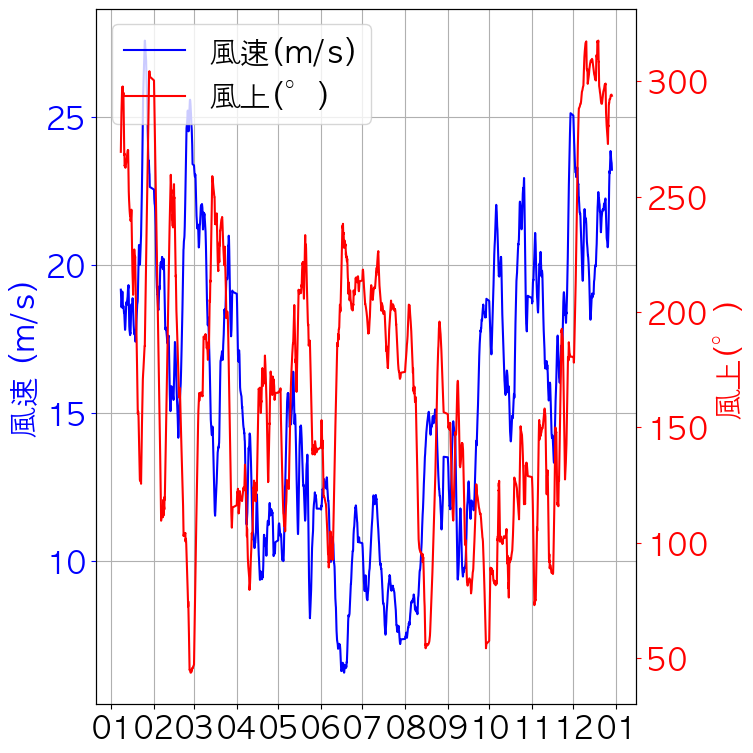

In [228]:
# グラフオプションを付けたり、データ後処理をする場合
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['font.size'] = 22
plt.rcParams["figure.figsize"]=8,8

fig, ax1 = plt.subplots() # グラフの作成（2つの縦軸を使用）

# 風速のプロット（左側の縦軸）
ax1.plot(df['date_hour'], 
         df['wind_speed'].rolling(window=24*7).mean(), 'b-', label='風速(m/s)')
#ax1.set_xlabel('月')
ax1.set_ylabel('風速 (m/s)', color='b')
ax1.tick_params('y', colors='b')
ax2 = ax1.twinx()# 風向のプロット（右側の縦軸）
#ax2.plot(df['date_hour'], df['wind_direction'], 'r-', label='Wind Direction (degrees)')
ax2.plot(df['date_hour'], 
         df['wind_direction'].rolling(window=24*7).mean(), 'r-', label='風上(°)')

ax2.set_ylabel('風上(°)', color='r')
ax2.tick_params('y', colors='r')
# グラフの装飾
#plt.title('Wind Speed and Direction over Time');ax1.grid(True, alpha=0.3)
# 凡例の追加
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.xticks(rotation=45) # x軸の時間表示を調整

# 1か月ごとにラベルを表示
ax1.xaxis.set_major_locator(mdates.MonthLocator())

# ラベルのフォーマットを設定（例: 2024-01）
#ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%m'))

# ラベルを斜めにして重なりを防ぐ
plt.xticks(rotation=45)

# グリッドを追加するとさらに見やすい
ax1.grid(True)

plt.tight_layout(); plt.show() # レイアウト調整をして表示

In [231]:
add_location(route,"",150,130);itokoku=add_location(route,"伊都国",55,370)
draw_map_and_locations([route])

In [232]:
nakoku=[itokoku];add_location(nakoku,"奴国",90,100)
draw_map_and_locations([route,nakoku])

In [ ]:
import requests
import time
import urllib.parse
from bs4 import BeautifulSoup # HTMLからのデータ抽出
from jp_pref.prefecture import name2code # pip install jp_pref

base_url="https://sitereports.nabunken.go.jp"

def get_response(url):# ページを取得する
    session = requests.Session()  # セッションを開始
    try:
        response = session.get(url)  # GETリクエストを投げる
        if response.status_code != 200:
            print(f"エラー: ステータスコード {response.status_code}")
    except requests.exceptions.RequestException as e:
        print(f"リクエスト中にエラーが発生しました: {e}")
    session.close(); time.sleep(5)  # Waitを入れておく
    return response

def get_page_num(response_text):# ページ数を取得する
    soup = BeautifulSoup(response_text, "html.parser")
    page_items = soup.select('ul.pagination li') # pagination内のli要素を取得
    # paginationがページ上下に付いているので2で割る、また、最後に飛ぶリンク分で-1    
    return 1 if len(page_items)==0 else int(len(page_items)/2-1)

def make_url(serch_options,page):#検索結果を表示するURLを作成する
    url = "/ja/search-site?has_file=x" if page==0 else f"/ja/search-site/p/{page+1}?has_file=x"
    url=base_url+url
    for key in serch_options:
        if type(serch_options[key])== list:
            for idx, item in enumerate(serch_options[key]):
                if type(serch_options[key])== list: # 複数指定するなら[]を付ける
                    url+=f"&{key}%5B%5D="+urllib.parse.quote(item)
                else: # 複数指定時も単一での指定時もitemはURLエンコードする
                    url+=f"&{key}="+urllib.parse.quote(item)   
        else:
            url+=f"&{key}="+urllib.parse.quote(serch_options[key])     
    return url

def fetch_results(response_text):# ページテキストから検索結果を取得する
    soup = BeautifulSoup(response_text,"html.parser")
    results = [] # 検索結果を格納する
    for doc in soup.select(".document_list_item"):
        # selectは、CSSセレクタ＝「クラス名指定はピリオドを前に付加する」で検索
        title = doc.select_one(".list_title").get_text(strip=True)
        url= doc.select_one(".list_title").find('a')['href']
        fields = doc.select_one(".fields").get_text(strip=True)
        results.append({"title": title, "url":url,
                        "fields": fields.replace('ほか', '').split()})
    return results

def getelevation(latlon): # 緯度経度から標高を返す　#https://maps.gsi.go.jp/development/elevation_s.html
    url="https://cyberjapandata2.gsi.go.jp/general/dem/scripts/getelevation.php?"
    url+=f"lon={latlon[1]}&lat={latlon[0]}&outtype=JSON"
    return get_response(url).json()["elevation"] # JSON返り値から標高を返す

def get_latlon(response_text):# 詳細ページのページテキストから緯度・経度を取得する
        soup = BeautifulSoup(response_text, "html.parser")
        results=[]; document_list = soup.select(".copy-clipboard-text")
        for doc in document_list:
            text=doc.get_text(strip=True)
            if set(text).issubset(set("0123456789. ")): # 緯度経度の書式なら
                latlon=text.split()
                latlon.append(getelevation(latlon)) # 標高も追加
                results.append(latlon) # [lat,lon,elevation]
        return results

def get_locations(search_options): # 
    # 検索URLを作成して最初のページにアクセスして、ページ内容と全ページ数を取得
    response_text=get_response(make_url(search_options,0)).text # ページ内容取得
    locations=[]# 検索条件に応じた検索結果を作成する。まずは最初のページから検索内容一覧を作る
    for l in fetch_results(response_text):
        locations.append(l)
    for i in range(get_page_num(response_text)-1):# 残りのページから、検索内容一覧を更新する
        locations+=fetch_results(get_response(make_url(search_options,i+1)).text)
    for loc in locations: # 詳細ページをもとに緯度経度も追加
        print(i)
        loc["latlons"]=get_latlon(get_response(base_url+loc['url']).text)
        print(loc)
    return locations

def prefs2codes(prefs): # 都道府県の名称リストをJIS X 0401-1973コードのリストに変換
    return [str(name2code(name)) for name in prefs]

In [ ]:
# コードを読み込場合
from nabunken_search import prefs2codes, get_locations

In [ ]:
pref_codes=prefs2codes(["福岡県","大分県","佐賀県","長崎県"])
locations=get_locations({"pref_code":pref_codes,"ibutu":"銅鏡",
  "age":["弥生","古墳"],"category":["集落","古墳","墓"]})

In [234]:
draw_map_and_locations([route,yamataikoku],locations)